In [21]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from trajectory import Joint
from trajectory.test.cpptest import CPPPlanner

cp = CPPPlanner('/Users/eric/Documents/proj/trajectory/src/cmake-cli-test/cli')

cp.make()

[ 66%] Built target libplanner
[ 83%] Built target planner
[100%] Built target stepper


In [18]:
# Write a test file
from pathlib import Path
from random import random, randint
p  =Path('/Users/eric/Documents/proj/trajectory/src/test/')
signs = [1,1,1]

with open(p/'stepper_file_test.txt', 'w') as f:
    for i in range(100):
        for axis in (0,1):
            signs[axis] = -signs[axis] if random() < .1 else signs[axis] # change direction 10% of the time
        x1 = signs[0]*int(random() < .90)*randint(0,10000)
        x2 = signs[1]*int(random() < .90)*randint(0,10000)
        x3 = signs[2]*int(random() < .90)*randint(0,10000)
        
        f.write(f"{x1} {x2} {x3}\n")




In [17]:
1/(4/1e6) / 1000

250.0

In [2]:
##
## Compare Python  blocks to CPP planner blocks
###
from trajectory.test.cpptest import * 
test_dir = '../src/cmake-cli-test/'

# Create the Python blocks
j = Joint(5000, 50_000)
s = Segment(0, j)

blocks = [
    Block(x=1000, v_0=0, v_1=0, joint=j, segment=s).plan(),       # A
    Block(x=1000, v_0=2500, v_1=2500, joint=j, segment=s).plan(), # B
    Block(x=1000, v_0=5000, v_1=5000, joint=j, segment=s).plan(), # C
    Block(x=200, v_0=5000, v_1=5000, joint=j, segment=s).plan(),  # D
    Block(x=1, v_0=5000, v_1=5000, joint=j, segment=s).plan(),    # E
    Block(x=1000, v_0=5000, v_1=0, joint=j, segment=s).plan(),    # F
    Block(x=1000, v_0=0, v_1=5000, joint=j, segment=s).plan(),    # G
    Block(x=400, v_0=5000, v_1=0, joint=j, segment=s).plan(),     # H
    Block(x=400, v_0=0, v_1=5000, joint=j, segment=s).plan(),     # I
    Block(x=150, v_0=5000, v_1=0, joint=j, segment=s).plan(),     # J
    Block(x=150, v_0=0, v_1=5000, joint=j, segment=s).plan()      # K
]
    
blocks = dict([ (k,v) for k,v in zip("ABCDEFGHIJK", blocks)])

# Run the test_planner program to get the c++ planner blocks
tp = TestPlanner(test_dir)
tp.make()
z = tp.run()
cblocks = z['low level block']['output']

n_diffs = 0
for cb in cblocks:
    b = blocks[cb['_tag']].asdict()
    for k, v in cb.items():
        diffs = compare_blocks(cb, b)
        n_diffs += len(diffs)
        if diffs:
            print(cb['_tag'], diffs)
                
if n_diffs == 0:
    print("No differences")

[ 57%] Built target libplanner
[100%] Built target test_planner
No differences


In [3]:

#
# Compare segments
#
tp = TestPlanner(test_dir)
tp.make()
s1 = tp.load_segment('basic_segment_1')

s2 = Segment(  0, s1.joints, s1.move)
s2.plan()

diffs = compare_seg(s1, s2)
assert len(diffs) == 0, diffs

[ 57%] Built target libplanner
[100%] Built target test_planner


In [4]:
tp = TestPlanner(test_dir)
tp.make()
s1 = tp.load_segment('basic_segment_2')

s2 = Segment(  0, s1.joints, s1.move)
s2.plan()

diffs = compare_seg(s1, s2)

assert len(diffs) == 0, diffs

[ 57%] Built target libplanner
[100%] Built target test_planner


In [5]:
#
# Compare the python planner to the CPP planner. 
#
LARGE = 1000
small = 1

j = Joint(5000, 50_000)
joints = [j,j]

moves = ([LARGE,small],[small,LARGE])

sl_p, sl_c = cp.compare_planner(joints, moves)
sl_p, sl_c


Pyp Time:  7721 μs
[ 66%] Built target libplanner
[ 83%] Built target planner
[100%] Built target stepper
CPP Time:  369 μs


(  0 0.0000 0.2996|[0        250 100  ↗5000      500 100  ↘250    100      19] [0          0 0    ↗3           1 298  ↘0      0        19]
  1 0.2996 0.2997|[19         0 0    ↗3           1 299  ↘0      0         0] [19       250 100  ↗4997      501 100  ↘250    100       0]
,
   0 0.0000 0.2996|[0        250 100  ↗5000      500 100  ↘250    100      19] [0          0 0    ↗3           1 298  ↘0      0        19]
  1 0.2996 0.2997|[19         0 0    ↗3           1 299  ↘0      0         0] [19       250 100  ↗4997      501 100  ↘250    100       0]
)

Pyp Time:  8407 μs
[ 66%] Built target libplanner
[ 83%] Built target planner
[100%] Built target stepper
CPP Time:  383 μs


(None, None)

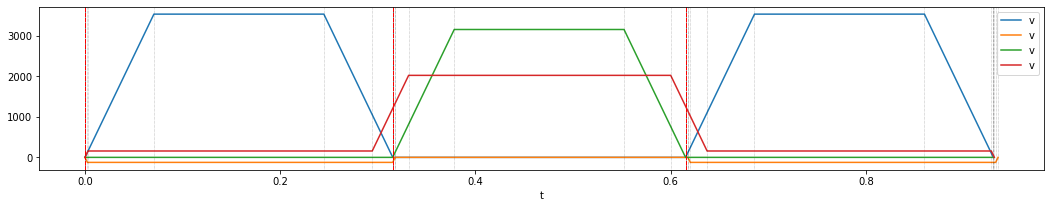

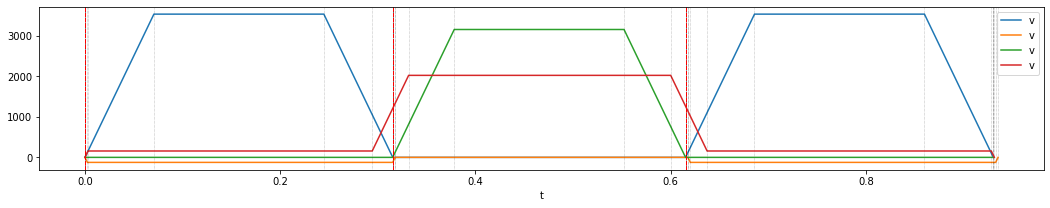

In [6]:

moves = [
    [864, -39, 0, 61],
    [0, 0, 747, 594],
    [864, -39, 0, 61]
]

sl_p, sl_c = cp.compare_planner([j,j,j,j], moves, report = True)
sl_p.plot(), sl_c.plot()


Pyp Time:  258946 μs 1282 μs per block
[ 66%] Built target libplanner
[ 83%] Built target planner
[100%] Built target stepper
CPP Time:  8678 μs 43 μs per block


(None, None)

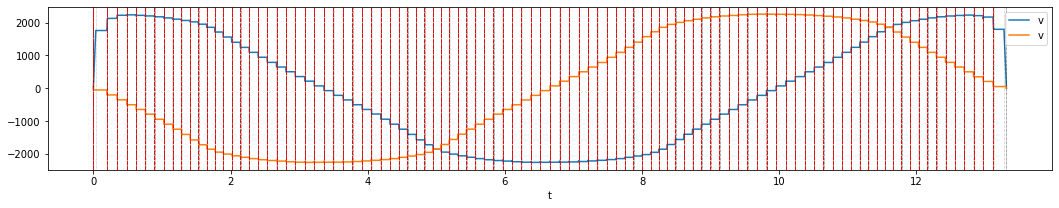

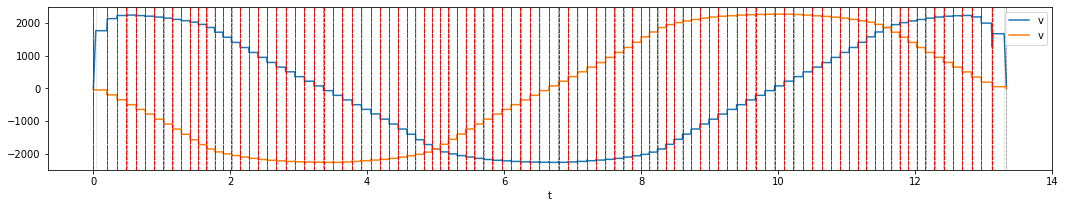

In [11]:
def make_circle(r=5000, n=100):
    from math import sin, cos
   
    moves = []

    r = r
    lx  = 0
    ly = r
    for i in range(0,n+1):
        a = 2*np.pi*(i/n)
        x = sin(a)*r 
        y = cos(a)*r 
        
        moves.append((round(x-lx),round(y-ly)))
        
        lx = x
        ly = y
            
    return moves

moves = make_circle(r=5000, n=100)

sl_p, sl_c = cp.compare_planner([j,j], moves, report = False)
sl_p.plot(), sl_c.plot()


In [8]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Serious discontinuities. 
from trajectory import * 
from trajectory.test.cpptest import * 

j = Joint(5_000, 50_000)
joints = [j]*2
sl = SegmentList(joints)   
sl.move([1000,500])
sl.move([500,1000])
sl.move([1000,500])
sl.move([500,1000])

ts = TestStepper('/Users/eric/Documents/proj/trajectory/src/cmake-cli-test/cli')
ts.run_stepper(sl)




[ 66%] Built target libplanner
[ 83%] Built target planner
[100%] Built target stepper
[(0,250,4998)/(4998,750,4998)/(4998,0,4996)] [(0,29,1703)/(1703,259,1703)/(1703,212,4914)] 
[(4996,249,155)/(155,1,155)/(155,249,4996)] [(4914,4,4955)/(4955,992,4955)/(4955,4,4911)] 
[(4996,0,5000)/(5000,1000,5000)/(5000,0,4999)] [(4911,237,625)/(625,17,625)/(625,246,4996)] 
[(4999,222,1664)/(1664,250,1664)/(1664,28,0)] [(4996,0,4998)/(4998,750,4998)/(4998,250,0)] 

0 62322 997 500 
1 49414 500 979 
2 50001 1000 505 
3 62551 497 1007 


In [9]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Serious discontinuities. 
from trajectory import * 
from trajectory.test.cpptest import * 

j = Joint(5_000, 50_000)
joints = [j]*2
sl = SegmentList(joints)   
sl.move([1000,500])
sl.move([500,1000])
sl.move([1000,500])
sl.move([500,1000])

ts = TestStepper('/Users/eric/Documents/proj/trajectory/src/cmake-cli-test/cli')
ts.run_stepper(sl)



[ 66%] Built target libplanner
[ 83%] Built target planner
[100%] Built target stepper
[(0,250,4998)/(4998,750,4998)/(4998,0,4996)] [(0,29,1703)/(1703,259,1703)/(1703,212,4914)] 
[(4996,249,155)/(155,1,155)/(155,249,4996)] [(4914,4,4955)/(4955,992,4955)/(4955,4,4911)] 
[(4996,0,5000)/(5000,1000,5000)/(5000,0,4999)] [(4911,237,625)/(625,17,625)/(625,246,4996)] 
[(4999,222,1664)/(1664,250,1664)/(1664,28,0)] [(4996,0,4998)/(4998,750,4998)/(4998,250,0)] 

0 62322 997 500 
1 49400 500 979 
2 50001 1000 505 
3 62551 497 1007 


[ 66%] Built target libplanner
[ 83%] Built target planner
[100%] Built target stepper


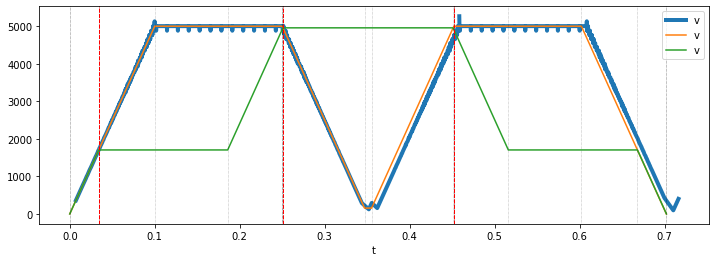

In [72]:
%reload_ext autoreload
%autoreload 2
%run startup.py

LARGE = 1000
small = 500

j = Joint(5000, 50_000)
joints = [j,j]

moves = ([LARGE,small],[small,LARGE], [LARGE,small])

cp.make()
l = cp.run_stepper(joints, moves)

df = pd.DataFrame(l, columns = ['t','x','y'])
t = df[['t','x']].copy()
t = t[t.x!=0]
v = (1/t.t.diff()).to_frame('v')
v = v[v<10000]
ax = t.join(v).plot('t','v', linewidth=4, figsize=(12,4))


sl = SegmentList(joints)   
[sl.move(m) for m in moves]
sl.plot(ax=ax)


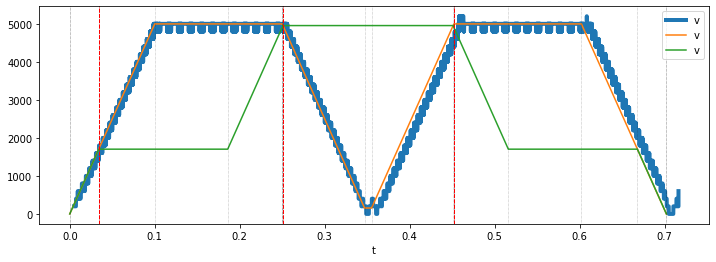

199999.99999999997